# Data Import

In [1]:
from os import listdir as ls
from os.path import join, isfile, expanduser
from glob import glob
from toolz import pipe, curry
from toolz.curried import reduce, map
from funcy import compose, rpartial, partial
from operator import add
import pandas as pd
import json

json_from = compose(json.load, open, join)

FOLDER_DIR = '~/Documents/data/gazecapture'
OUT_CSV = './eye-gaze-capture.csv'

READ_FUNCS = { 'motion': compose(pd.DataFrame.from_dict, json_from) }

FRAME_TYPES = ['appleRightEye', 'appleLeftEye', 'appleFace',
               'frames', 'screen', 'faceGrid', 'dotInfo']

frame_paths = compose(
    sorted,
    map(lambda p: '/'.join(p.split('/')[-3:])),
    glob,
    rpartial(join, 'frames/*.jpg')
)

@curry
def data_type_from_folder(folder_path, data_type):
    read_func = READ_FUNCS.get(data_type, json_from)
    
    # Load raw JSON
    raw = read_func(folder_path, data_type + '.json')
    
    # Create data frame
    df = raw if isinstance(raw, pd.DataFrame) else pd.DataFrame(data = raw)
    
    # Prefix columns with file_type
    df = df.add_prefix(data_type + '.')
    
    # Add corresponding frames
    df['Frame'] = frame_paths(folder_path)
    
    return df

@curry
def join_on(key, df1, df2):
    return df1.join(df2.set_index(key), on = key)

@curry
def append_info(folder_path, df):
    info = json_from(folder_path, 'info.json')
    df['Dataset'] = info['Dataset']
    df['DeviceName'] = info['DeviceName']
    return df

def folder_df(folder_path):
    return pipe(
        map(data_type_from_folder(folder_path), FRAME_TYPES),
        reduce(join_on('Frame')),
        append_info(folder_path))

def write_folder_df(df, path = OUT_CSV):
    mode = 'a' if isfile(path) else 'w'
    header = not isfile(path)
    df.to_csv(path, mode = mode, header = header, index = False)
    return df.shape[0]

collect_data = compose(
    reduce(add),
    map(compose(write_folder_df, folder_df)),
    glob,
    expanduser,
    rpartial(join, '*/')
)

# Basic Data

In [2]:
from itertools import takewhile

id_of_frame = compose(''.join, partial(takewhile, lambda x: x != '/'))

# Read data back in from CSV
capture_df = pd.read_csv(OUT_CSV)
capture_df['SessionID'] = capture_df.Frame.apply(id_of_frame)

In [3]:
capture_df.shape

(2445504, 34)

In [4]:
capture_df.columns

Index(['appleRightEye.H', 'appleRightEye.W', 'appleRightEye.X',
       'appleRightEye.Y', 'appleRightEye.IsValid', 'Frame', 'appleLeftEye.H',
       'appleLeftEye.W', 'appleLeftEye.X', 'appleLeftEye.Y',
       'appleLeftEye.IsValid', 'appleFace.H', 'appleFace.W', 'appleFace.X',
       'appleFace.Y', 'appleFace.IsValid', 'frames.0', 'screen.H', 'screen.W',
       'screen.Orientation', 'faceGrid.X', 'faceGrid.Y', 'faceGrid.W',
       'faceGrid.H', 'faceGrid.IsValid', 'dotInfo.DotNum', 'dotInfo.XPts',
       'dotInfo.YPts', 'dotInfo.XCam', 'dotInfo.YCam', 'dotInfo.Time',
       'Dataset', 'DeviceName', 'SessionID'],
      dtype='object')

In [5]:
filtered_df = capture_df[capture_df['faceGrid.IsValid'] == True]

print('Frames with facial features: {0:.2f}% ({1} records)'.format(
    100 * filtered_df.shape[0] / capture_df.shape[0],
    filtered_df.shape[0]
))

Frames with facial features: 92.33% (2258008 records)


# Categorical Data

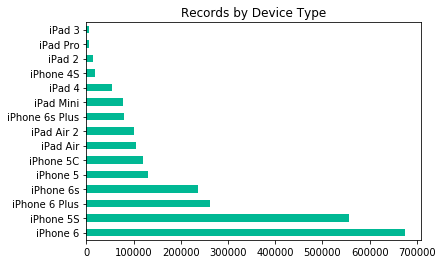

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

capture_df.DeviceName.value_counts().plot.barh(color='#00b894')
plt.title('Records by Device Type')
plt.show()

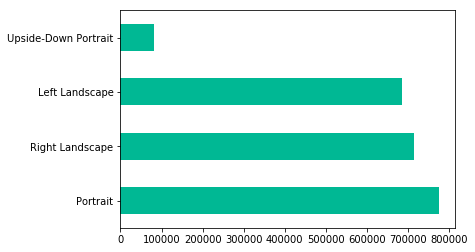

In [7]:
orientation = filtered_df['screen.Orientation'].astype('category')
orientation.cat.categories = ['Portrait', 'Upside-Down Portrait', 'Left Landscape', 'Right Landscape']
orientation.value_counts().plot.barh(color='#00b894')

# Frames

(Faces grayscale and blurred for privacy)


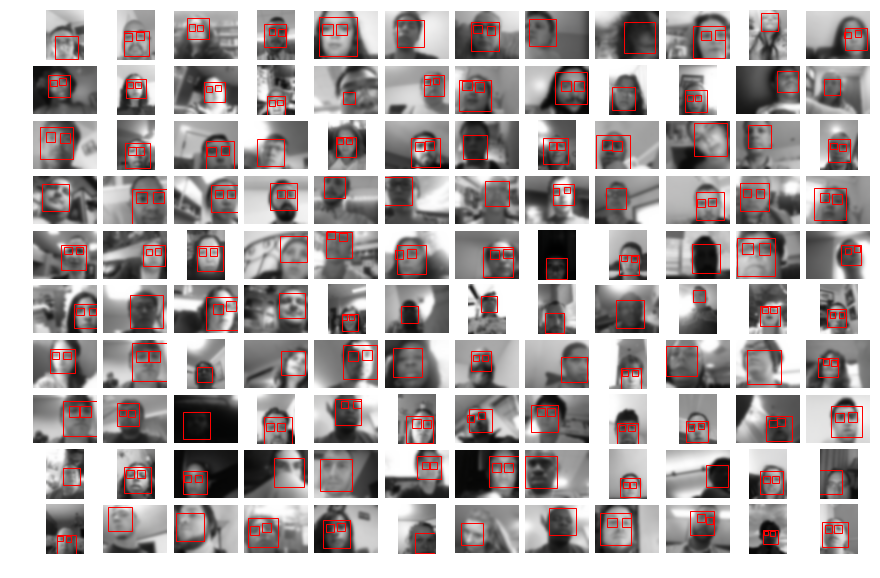

In [8]:
import matplotlib as mpl
import scipy.ndimage as ndimage
from random import sample as rand_subset

mpl.rcParams['figure.figsize'] = (15, 10)

@curry
def col(key, row):
    return row[key]

from_dir = partial(join, expanduser(FOLDER_DIR))

frame = compose(rpartial(ndimage.gaussian_filter, (14)),
                mpl.image.imread, from_dir, col('Frame'))

def rect(x, y, w, h, row):
    return mpl.patches.Rectangle(
        (x, y), w, h,
        linewidth=1,
        edgecolor='r',
        facecolor='none')

@curry
def optional_val(key, prefix, row):
    return 0 if prefix is None else col(prefix + '.' + key, row)

x_col = optional_val('X')
y_col = optional_val('Y')
w_col = optional_val('W')
h_col = optional_val('H')

def rect_prefix(prefix, row, relative_to = None):
    return rect(x_col(prefix, row) + x_col(relative_to, row),
                y_col(prefix, row) + y_col(relative_to, row),
                w_col(prefix, row),
                h_col(prefix, row),
                row)

def display_detections(row, axis = None):
    axis.set_axis_off()
    axis.imshow(frame(row))
    axis.add_patch(rect_prefix('appleFace', row))
    axis.add_patch(rect_prefix('appleLeftEye', row, relative_to = 'appleFace'))
    axis.add_patch(rect_prefix('appleRightEye', row, relative_to = 'appleFace'))


figure, axarr = plt.subplots(10, 12, gridspec_kw = dict(wspace=0.1, hspace=0.1))

for idx, axis in zip(rand_subset(range(filtered_df.shape[0]), 120), axarr.flatten()):
    display_detections(filtered_df.iloc[idx], axis)

print('(Faces grayscale and blurred for privacy)')
plt.show()

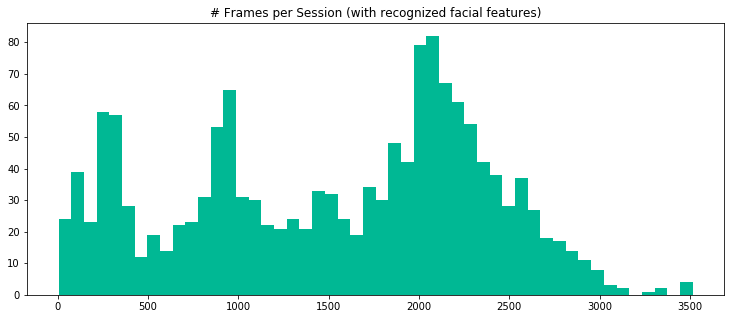

In [9]:
original_size = mpl.rcParams['figure.figsize']
mpl.rcParams['figure.figsize'] = (12.5, 5)

filtered_df.SessionID.value_counts().hist(
    color='#00b894', grid=False, bins=50)
plt.title('# Frames per Session (with recognized facial features)')
plt.show()

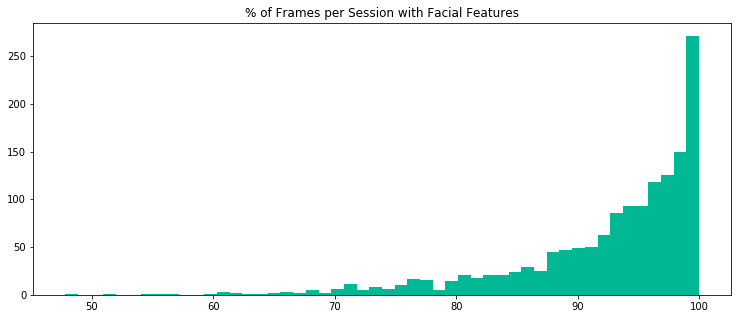

In [10]:
(capture_df
    .groupby('SessionID')['faceGrid.IsValid']
    .agg(['sum', 'count'])
    .agg(lambda x: 100 * x[0] / x[1], axis='columns').hist(
        color='#00b894', grid=False, bins=50))

plt.title('% of Frames per Session with Facial Features')
plt.show()

mpl.rcParams['figure.figsize'] = original_size

# Dot Info

In [11]:
pd.options.display.float_format = '{:.2f}'.format

filtered_df[['dotInfo.XPts', 'dotInfo.YPts', 'dotInfo.XCam', 'dotInfo.YCam']].describe()

,dotInfo.XPts,dotInfo.YPts,dotInfo.XCam,dotInfo.YCam
count,2258008.00,2258008.00,2258008.00,2258008.00
mean,294.22,260.50,0.12,-1.85
std,200.75,190.86,6.08,4.87
min,40.00,40.00,-26.52,-26.52
25%,139.73,116.07,-3.72,-4.23
50%,261.64,220.00,0.40,-1.24
75%,414.28,335.00,3.67,0.94
max,1326.00,1326.00,26.52,26.52


## Dot Info (in Screen Points)

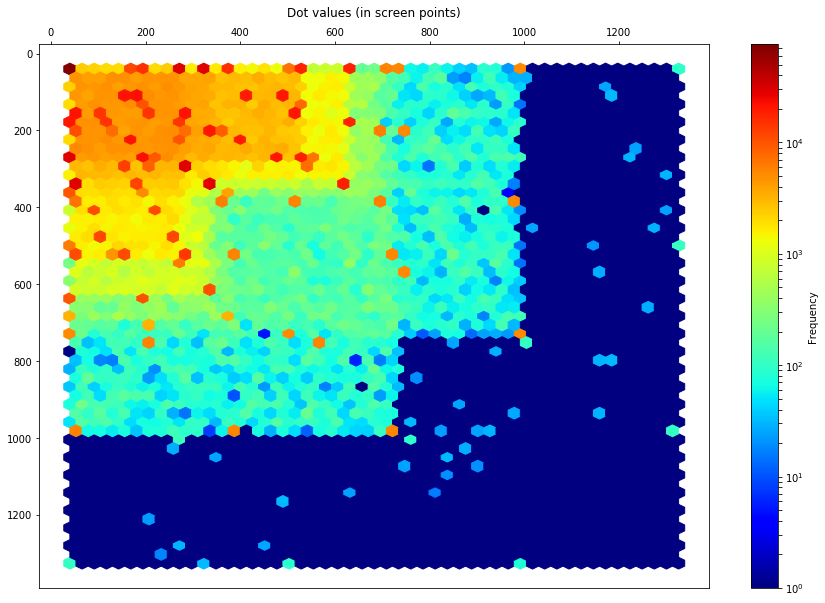

In [12]:
plt.hexbin(filtered_df['dotInfo.XPts'],
           filtered_df['dotInfo.YPts'],
           gridsize=50, cmap=mpl.cm.jet, norm=mpl.colors.LogNorm())
plt.title('Dot values (in screen points)')

cb = plt.colorbar()
cb.set_label('Frequency')

# Invert axis to correspond to iOS origin in upper-left
axis = plt.gca()
axis.set_ylim(axis.get_ylim()[::-1])
axis.xaxis.tick_top()
axis.yaxis.tick_left()
axis.title.set_position([0.5, 1.04])

plt.show()

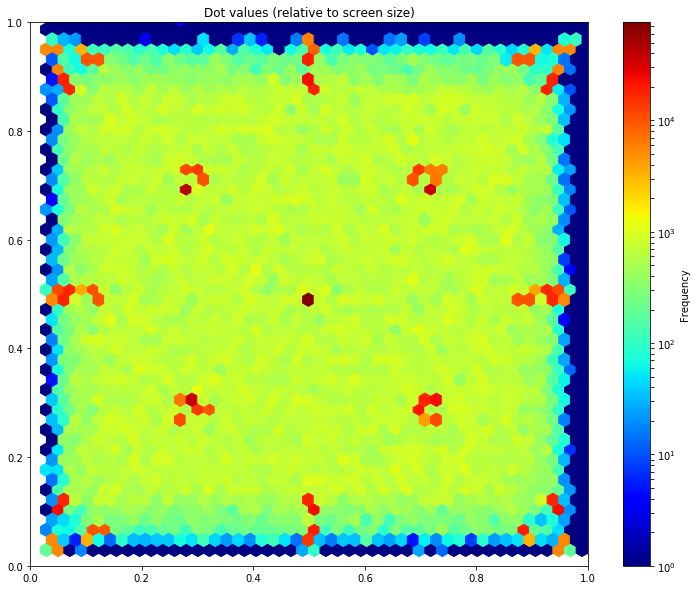

In [13]:
original_size = mpl.rcParams['figure.figsize']
mpl.rcParams['figure.figsize'] = (12.5, 10)

plt.hexbin(filtered_df['dotInfo.XPts'] / filtered_df['screen.W'],
           filtered_df['dotInfo.YPts'] / filtered_df['screen.H'],
           gridsize=60, cmap=mpl.cm.jet, norm=mpl.colors.LogNorm())
plt.title('Dot values (relative to screen size)')

plt.axis([0, 1, 0, 1])

cb = plt.colorbar()
cb.set_label('Frequency')

plt.show()

mpl.rcParams['figure.figsize'] = original_size

## Dot Info (Relative to Camera)

> `XCam`, `YCam`: Position of the center of the dot in our prediction space. The position is measured in centimeters and is relative to the camera center, assuming the camera remains in a fixed position in space across all device orientations. I.e., YCam values will be negative for portrait mode frames (`Orientation` == 1) since the screen is below the camera, but values will be positive in upside-down portrait mode (`Orientation` == 2) since the screen is above the camera.

(Source: https://github.com/CSAILVision/GazeCapture)

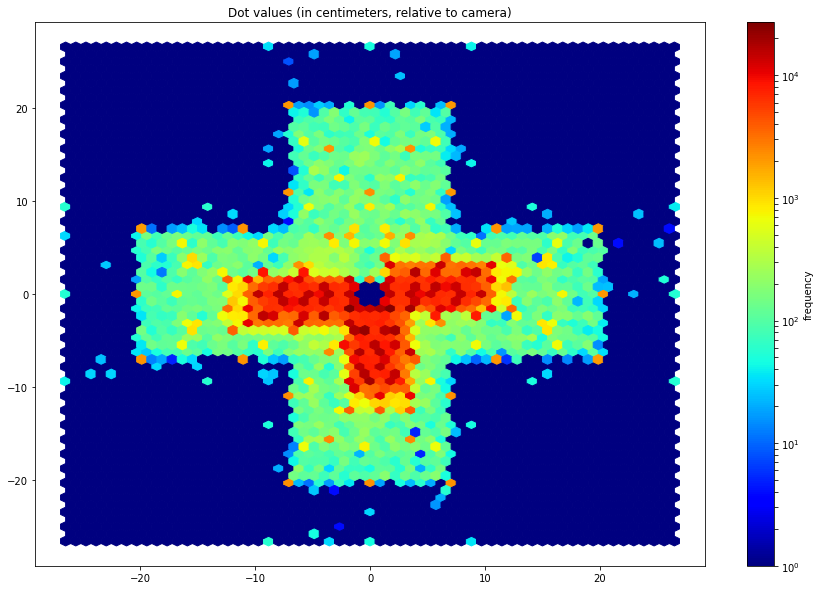

In [14]:
plt.hexbin(filtered_df['dotInfo.XCam'],
           filtered_df['dotInfo.YCam'],
           gridsize=60, cmap=mpl.cm.jet, norm=mpl.colors.LogNorm())
plt.title('Dot values (in centimeters, relative to camera)')

cb = plt.colorbar()
cb.set_label('frequency')
plt.show()